# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '06'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="rimedice"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 265513)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 16:33:46 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_rimedice.values
    n_s  = xr.open_dataset(fname).n_rimedice.values
    r_s  = xr.open_dataset(fname).rime_rimedice.values
    v_s  = xr.open_dataset(fname).rvol_rimedice.values
    # reflectivity
    z_s  = xr.open_dataset(fname).z_rimedice.values
    # some numerical lower bounds
    q_min = 1e-20
    n_min = 1e-20
    z_min = 1e-20
    p_min = 1e-20
    # transform everything in log space
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    r_s = np.log(r_s, where=r_s>q_min, out=np.nan*n_s)
    v_s = np.log(v_s, where=v_s>q_min, out=np.nan*n_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*n_s)
    z_s = np.log(z_s, where=z_s>q_min, out=np.nan*n_s)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ z_s, q_s, n_s, r_s, v_s, temp, rho ]))
    dataset = dataset.T
    dataset.columns = [ 'z_s', 'q_s', 'n_s', 'r_s', 'v_s', 'temp', 'rho' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

In [8]:
df.describe()

z_s            q_s            n_s            r_s  \
count  265512.000000  265512.000000  265512.000000  265512.000000   
mean      -31.224213     -12.260329       7.080263     -13.426891   
std         3.154670       2.702370       2.883721       2.937405   
min       -45.986195     -23.024351     -14.498609     -32.056206   
25%       -33.048230     -13.748787       5.646330     -15.080437   
50%       -31.186997     -12.130353       7.299392     -13.301699   
75%       -29.096272     -10.360157       8.958052     -11.447489   
max         5.199601      -4.456319      16.136034      -4.653678   

                 v_s           temp            rho  
count  265512.000000  265512.000000  265512.000000  
mean      -18.765781     264.228027       0.997332  
std         3.002645       7.579132       0.122954  
min       -37.508041     245.570007       0.711000  
25%       -20.455225     258.130005       0.896000  
50%       -18.640162     265.390015       1.005000  
75%       -16.770653     271.179993       1.099000  
max       -11.166290     282.420013       1.288000

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

z_s        q_s       n_s        r_s        v_s        temp    rho
1 -30.939631 -11.692698  7.744050 -15.343876 -20.366152  265.950012  1.039
2 -30.869232 -11.652073  7.759742 -14.838218 -19.867702  266.019989  1.040
3 -30.806095 -11.620110  7.761234 -14.531169 -19.568178  266.079987  1.041
4 -30.746235 -11.591861  7.757564 -14.299613 -19.343794  266.140015  1.042
5 -30.689373 -11.564956  7.753838 -14.119457 -19.170822  266.209991  1.043

In [11]:
dataset_train.describe()

z_s            q_s            n_s            r_s  \
count  186185.000000  186185.000000  186185.000000  186185.000000   
mean      -31.221869     -12.257518       7.083708     -13.424719   
std         3.154298       2.702397       2.882948       2.936377   
min       -45.986195     -23.024351     -14.498609     -28.988184   
25%       -33.044636     -13.746358       5.648974     -15.075524   
50%       -31.182262     -12.122890       7.306129     -13.297372   
75%       -29.094500     -10.352748       8.961238     -11.443027   
max         5.199601      -4.456319      16.136034      -4.653678   

                 v_s           temp            rho  
count  186185.000000  186185.000000  186185.000000  
mean      -18.763382     264.221405       0.997202  
std         3.001563       7.579573       0.122986  
min       -34.686558     245.570007       0.712000  
25%       -20.449961     258.119995       0.896000  
50%       -18.636774     265.390015       1.005000  
75%       -16.768259     271.170013       1.098000  
max       -11.201185     282.420013       1.288000

In [12]:
dataset_test.describe()

z_s           q_s           n_s           r_s           v_s  \
count  39732.000000  39732.000000  39732.000000  39732.000000  39732.000000   
mean     -31.220474    -12.260788      7.075864    -13.426102    -18.764961   
std        3.143737      2.701783      2.882007      2.937857      3.004064   
min      -45.450230    -23.009878    -14.498609    -28.580921    -34.889866   
25%      -33.046619    -13.745518      5.662544    -15.075349    -20.443913   
50%      -31.182525    -12.138881      7.288347    -13.307880    -18.647380   
75%      -29.091156    -10.381821      8.964424    -11.453643    -16.772422   
max        4.999642     -4.464626     15.814095     -4.663955    -11.166290   

               temp           rho  
count  39732.000000  39732.000000  
mean     264.322845      0.998867  
std        7.556688      0.122675  
min      245.660004      0.712000  
25%      258.277496      0.898000  
50%      265.549988      1.007000  
75%      271.269989      1.100000  
max      282.250000      1.288000

In [13]:
dataset_val.describe()

z_s           q_s           n_s           r_s           v_s  \
count  39595.000000  39595.000000  39595.000000  39595.000000  39595.000000   
mean     -31.238991    -12.273079      7.068480    -13.437898    -18.777887   
std        3.167379      2.702862      2.889102      2.941831      3.006353   
min      -45.419579    -23.023455    -14.498609    -32.056206    -37.508041   
25%      -33.065811    -13.763108      5.618388    -15.100531    -20.481929   
50%      -31.210615    -12.160430      7.280904    -13.312919    -18.648310   
75%      -29.120456    -10.376102      8.934435    -11.461900    -16.779764   
max        5.186436     -4.585662     16.058048     -4.808536    -11.312355   

               temp           rho  
count  39595.000000  39595.000000  
mean     264.163971      0.996400  
std        7.598833      0.123072  
min      245.600006      0.711000  
25%      258.005005      0.895000  
50%      265.269989      1.004000  
75%      271.130005      1.098000  
max      281.989990      1.287000

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -15 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['n_s'] < 0 ].index
    dataset.drop(idx,inplace=True)   
#    idx = dataset[ dataset['z_s'] > -1 ].index
#    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

z_s            q_s            n_s            r_s  \
count  161476.000000  161476.000000  161476.000000  161476.000000   
mean      -30.490215     -11.525977       7.828919     -12.666247   
std         2.398724       1.945343       2.068202       2.197407   
min       -37.440689     -14.999909       0.171850     -23.285101   
25%       -32.287439     -13.098232       6.378587     -14.359846   
50%       -30.680291     -11.696782       7.709936     -12.858385   
75%       -28.756599     -10.087759       9.230731     -11.131872   
max       -23.289139      -5.269536      16.136034      -6.025973   

                 v_s           temp            rho  
count  161476.000000  161476.000000  161476.000000  
mean      -17.986305     264.030579       0.994432  
std         2.238870       7.535663       0.121973  
min       -29.434834     245.880005       0.712000  
25%       -19.713531     257.859985       0.893000  
50%       -18.183358     265.200012       1.002000  
75%       -16.450426     270.869995       1.095000  
max       -11.201185     274.700012       1.288000

In [17]:
dataset_test.describe()

z_s           q_s           n_s           r_s           v_s  \
count  34489.000000  34489.000000  34489.000000  34489.000000  34489.000000   
mean     -30.493727    -11.531989      7.820261    -12.671224    -17.991421   
std        2.402419      1.944625      2.066453      2.205255      2.247342   
min      -37.446075    -14.999616      0.000000    -20.218861    -26.442020   
25%      -32.280602    -13.090477      6.388343    -14.356778    -19.709848   
50%      -30.691441    -11.714381      7.695621    -12.885159    -18.204119   
75%      -28.751633    -10.111447      9.226411    -11.134626    -16.453974   
max      -23.349436     -5.302948     15.814095     -5.991785    -11.166290   

               temp           rho  
count  34489.000000  34489.000000  
mean     264.124054      0.995996  
std        7.516542      0.121853  
min      246.350006      0.712000  
25%      258.000000      0.895000  
50%      265.329987      1.004000  
75%      270.980011      1.096000  
max      274.730011      1.288000

### Pairplot

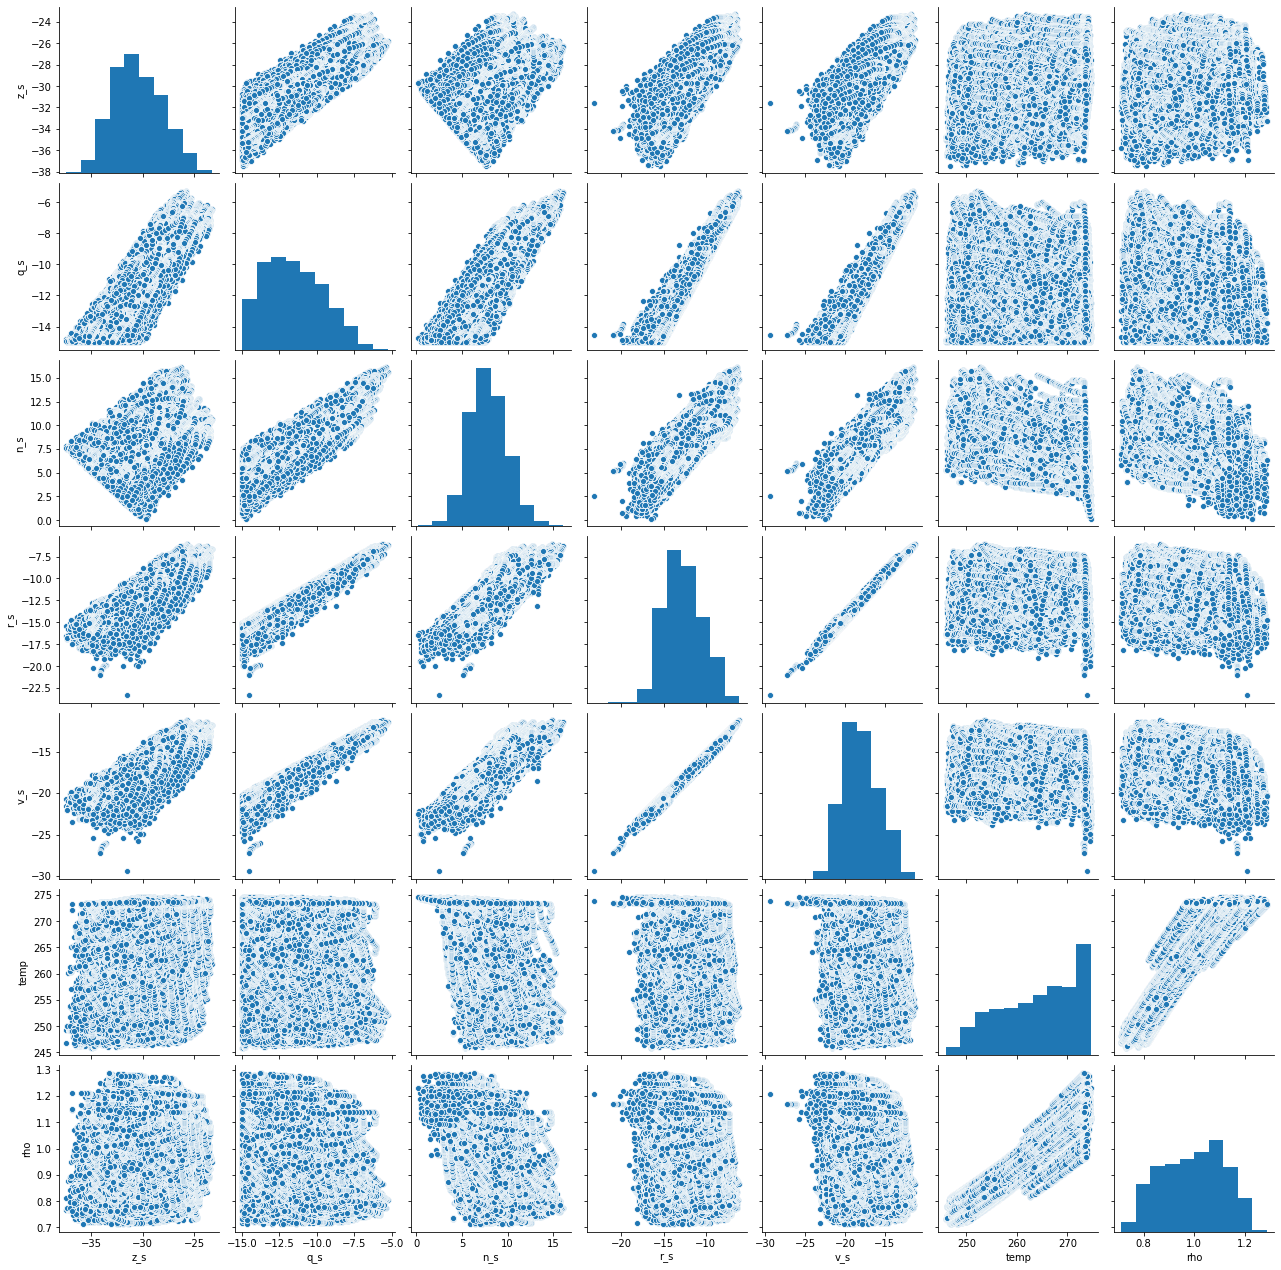

In [18]:
sns.pairplot(dataset_train[["z_s","q_s","n_s","r_s","v_s","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()
train_dataset5 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()
test_dataset5 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()
val_dataset5 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['temp','rho'], axis=1)
train_dataset2 = train_dataset2.drop(['temp'], axis=1)
#train_dataset3 = train_dataset3.drop(['ssi'], axis=1)
#train_dataset4 = train_dataset4.drop(['zi'], axis=1)
#train_dataset5 = train_dataset5.drop(['qs'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['temp','rho'], axis=1)
test_dataset2 = test_dataset2.drop(['temp'], axis=1)
#test_dataset3 = test_dataset3.drop(['ssi'], axis=1)
#test_dataset4 = test_dataset4.drop(['zi'], axis=1)
#test_dataset5 = test_dataset5.drop(['qs'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['temp','rho'], axis=1)
val_dataset2 = val_dataset2.drop(['temp'], axis=1)
#val_dataset3 = val_dataset3.drop(['ssi'], axis=1)
#val_dataset4 = val_dataset4.drop(['zi'], axis=1)
#val_dataset5 = val_dataset5.drop(['qs'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("z_s")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
q_s  161476.0 -11.525977  1.945343 -14.999909 -13.098232 -11.696782   
n_s  161476.0   7.828919  2.068202   0.171850   6.378587   7.709936   
r_s  161476.0 -12.666247  2.197407 -23.285101 -14.359846 -12.858385   
v_s  161476.0 -17.986305  2.238870 -29.434834 -19.713531 -18.183358   

           75%        max  
q_s -10.087759  -5.269536  
n_s   9.230731  16.136034  
r_s -11.131872  -6.025973  
v_s -16.450426 -11.201185

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("z_s")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%  \
q_s  161476.0 -11.525977  1.945343 -14.999909 -13.098232 -11.696782   
n_s  161476.0   7.828919  2.068202   0.171850   6.378587   7.709936   
r_s  161476.0 -12.666247  2.197407 -23.285101 -14.359846 -12.858385   
v_s  161476.0 -17.986305  2.238870 -29.434834 -19.713531 -18.183358   
rho  161476.0   0.994432  0.121973   0.712000   0.893000   1.002000   

           75%        max  
q_s -10.087759  -5.269536  
n_s   9.230731  16.136034  
r_s -11.131872  -6.025973  
v_s -16.450426 -11.201185  
rho   1.095000   1.288000

In [27]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("z_s")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean       std         min         25%         50%  \
q_s   161476.0  -11.525977  1.945343  -14.999909  -13.098232  -11.696782   
n_s   161476.0    7.828919  2.068202    0.171850    6.378587    7.709936   
r_s   161476.0  -12.666247  2.197407  -23.285101  -14.359846  -12.858385   
v_s   161476.0  -17.986305  2.238870  -29.434834  -19.713531  -18.183358   
temp  161476.0  264.030579  7.535663  245.880005  257.859985  265.200012   
rho   161476.0    0.994432  0.121973    0.712000    0.893000    1.002000   

             75%         max  
q_s   -10.087759   -5.269536  
n_s     9.230731   16.136034  
r_s   -11.131872   -6.025973  
v_s   -16.450426  -11.201185  
temp  270.869995  274.700012  
rho     1.095000    1.288000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [28]:
# pop does not work for multiple columns, use copy instead

labels = [ 'z_s' ]

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [31]:
train_labels.describe()

z_s
count  161476.000000
mean      -30.490215
std         2.398724
min       -37.440689
25%       -32.287439
50%       -30.680291
75%       -28.756599
max       -23.289139

In [32]:
train_dataset1.describe()

q_s            n_s            r_s            v_s
count  161476.000000  161476.000000  161476.000000  161476.000000
mean      -11.525977       7.828919     -12.666247     -17.986305
std         1.945343       2.068202       2.197407       2.238870
min       -14.999909       0.171850     -23.285101     -29.434834
25%       -13.098232       6.378587     -14.359846     -19.713531
50%       -11.696782       7.709936     -12.858385     -18.183358
75%       -10.087759       9.230731     -11.131872     -16.450426
max        -5.269536      16.136034      -6.025973     -11.201185

In [33]:
train_dataset2.describe()

q_s            n_s            r_s            v_s  \
count  161476.000000  161476.000000  161476.000000  161476.000000   
mean      -11.525977       7.828919     -12.666247     -17.986305   
std         1.945343       2.068202       2.197407       2.238870   
min       -14.999909       0.171850     -23.285101     -29.434834   
25%       -13.098232       6.378587     -14.359846     -19.713531   
50%       -11.696782       7.709936     -12.858385     -18.183358   
75%       -10.087759       9.230731     -11.131872     -16.450426   
max        -5.269536      16.136034      -6.025973     -11.201185   

                 rho  
count  161476.000000  
mean        0.994432  
std         0.121973  
min         0.712000  
25%         0.893000  
50%         1.002000  
75%         1.095000  
max         1.288000

In [34]:
train_dataset3.describe()

q_s            n_s            r_s            v_s  \
count  161476.000000  161476.000000  161476.000000  161476.000000   
mean      -11.525977       7.828919     -12.666247     -17.986305   
std         1.945343       2.068202       2.197407       2.238870   
min       -14.999909       0.171850     -23.285101     -29.434834   
25%       -13.098232       6.378587     -14.359846     -19.713531   
50%       -11.696782       7.709936     -12.858385     -18.183358   
75%       -10.087759       9.230731     -11.131872     -16.450426   
max        -5.269536      16.136034      -6.025973     -11.201185   

                temp            rho  
count  161476.000000  161476.000000  
mean      264.030579       0.994432  
std         7.535663       0.121973  
min       245.880005       0.712000  
25%       257.859985       0.893000  
50%       265.200012       1.002000  
75%       270.869995       1.095000  
max       274.700012       1.288000

### Normalize the features

In [35]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [36]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s  161476.0 -3.101034e-07  1.0 -1.785768 -0.808214 -0.087802  0.739313   
n_s  161476.0 -2.081089e-07  1.0 -3.702284 -0.701253 -0.057530  0.677793   
r_s  161476.0 -5.189958e-09  1.0 -4.832447 -0.770726 -0.087438  0.698266   
v_s  161476.0  3.317962e-07  1.0 -5.113530 -0.771472 -0.088014  0.686006   

          max  
q_s  3.216112  
n_s  4.016589  
r_s  3.021868  
v_s  3.030600

In [37]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_s  161476.0 -3.101034e-07  1.0 -1.785768 -0.808214 -0.087802  0.739313   
n_s  161476.0 -2.081089e-07  1.0 -3.702284 -0.701253 -0.057530  0.677793   
r_s  161476.0 -5.189958e-09  1.0 -4.832447 -0.770726 -0.087438  0.698266   
v_s  161476.0  3.317962e-07  1.0 -5.113530 -0.771472 -0.088014  0.686006   
rho  161476.0  1.747872e-06  1.0 -2.315533 -0.831598  0.062043  0.824508   

          max  
q_s  3.216112  
n_s  4.016589  
r_s  3.021868  
v_s  3.030600  
rho  2.406826

In [38]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
q_s   161476.0 -3.101034e-07  1.0 -1.785768 -0.808214 -0.087802  0.739313   
n_s   161476.0 -2.081089e-07  1.0 -3.702284 -0.701253 -0.057530  0.677793   
r_s   161476.0 -5.189958e-09  1.0 -4.832447 -0.770726 -0.087438  0.698266   
v_s   161476.0  3.317962e-07  1.0 -5.113530 -0.771472 -0.088014  0.686006   
temp  161476.0 -3.508699e-06  1.0 -2.408623 -0.818852  0.155187  0.907607   
rho   161476.0  1.747872e-06  1.0 -2.315533 -0.831598  0.062043  0.824508   

           max  
q_s   3.216112  
n_s   4.016589  
r_s   3.021868  
v_s   3.030600  
temp  1.415859  
rho   2.406826

### Normalize the labels

In [39]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%        50%  \
z_s  161476.0 -30.490215  2.398724 -37.440689 -32.287439 -30.680291   

           75%        max  
z_s -28.756599 -23.289139

In [40]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [41]:
DNNstring='16x16x16'

def build_model_sigm(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [42]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(4,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [44]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.844217  ],
       [-0.84794044],
       [-0.85033774],
       [-0.85221094],
       [-0.8536949 ],
       [-0.8548778 ],
       [-0.8558724 ],
       [-0.8567433 ],
       [-0.8574495 ],
       [-0.85938907]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [45]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [46]:
activ = "ReLU"
model4 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history4 = model4.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0155,  mae:0.0769,  mse:0.0155,  val_loss:0.0087,  val_mae:0.0706,  val_mse:0.0087,  
........................

Text(0, 0.5, 'MAE')

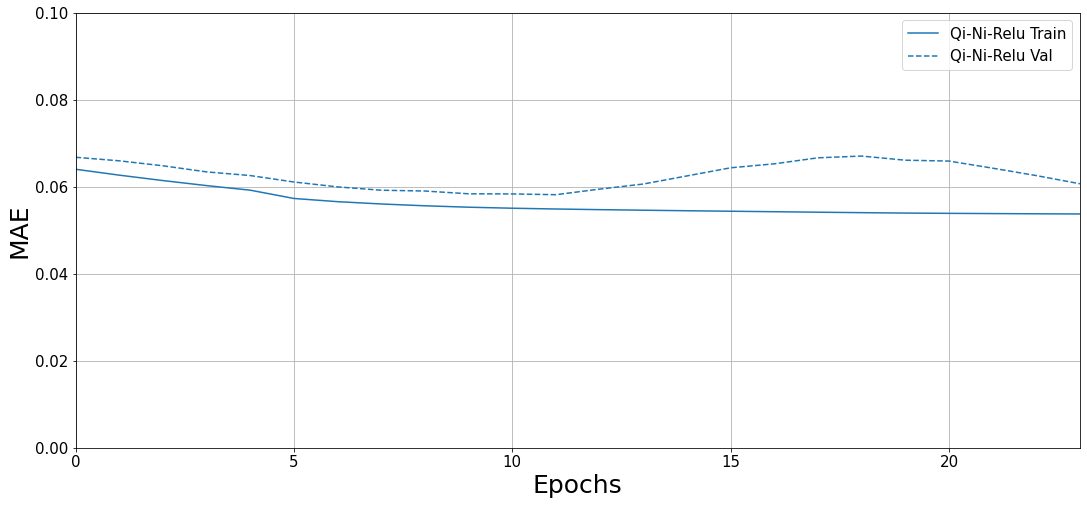

In [47]:
histories['qi-ni-ReLU'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.1])
plt.ylabel('MAE')

In [48]:
model5 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history5 = model5.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0163,  mae:0.0844,  mse:0.0163,  val_loss:0.0076,  val_mae:0.0654,  val_mse:0.0076,  
...............................

Text(0, 0.5, 'MAE')

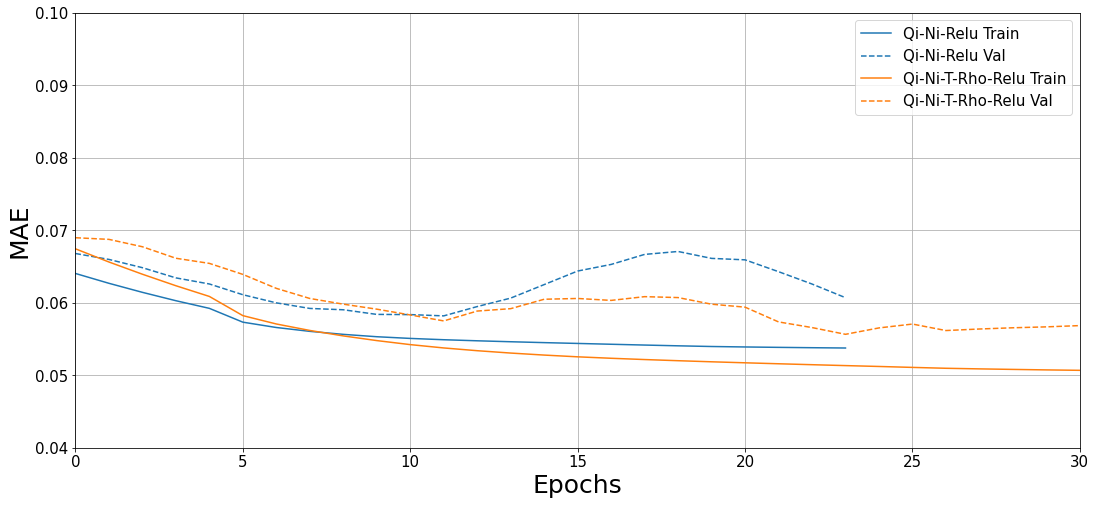

In [49]:
histories['qi-ni-T-rho-ReLU'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.1])
plt.ylabel('MAE')

In [50]:
activ = "ReLU_Adam"
model6 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history6 = model6.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0184,  mae:0.0796,  mse:0.0184,  val_loss:0.0068,  val_mae:0.0600,  val_mse:0.0068,  
...................................................................

Text(0, 0.5, 'MAE')

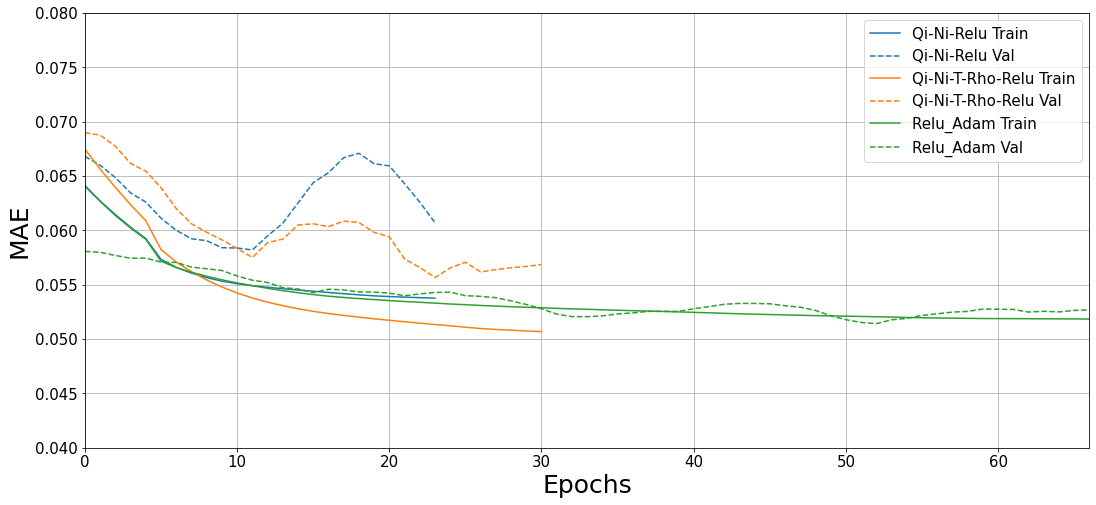

In [52]:
histories['ReLU_Adam'] = early_history6

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.08])
plt.ylabel('MAE')

In [53]:
activ = "ReLU_Adam"
model7 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history7 = model7.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0208,  mae:0.0917,  mse:0.0208,  val_loss:0.0081,  val_mae:0.0672,  val_mse:0.0081,  
.......................................................................

Text(0, 0.5, 'MAE')

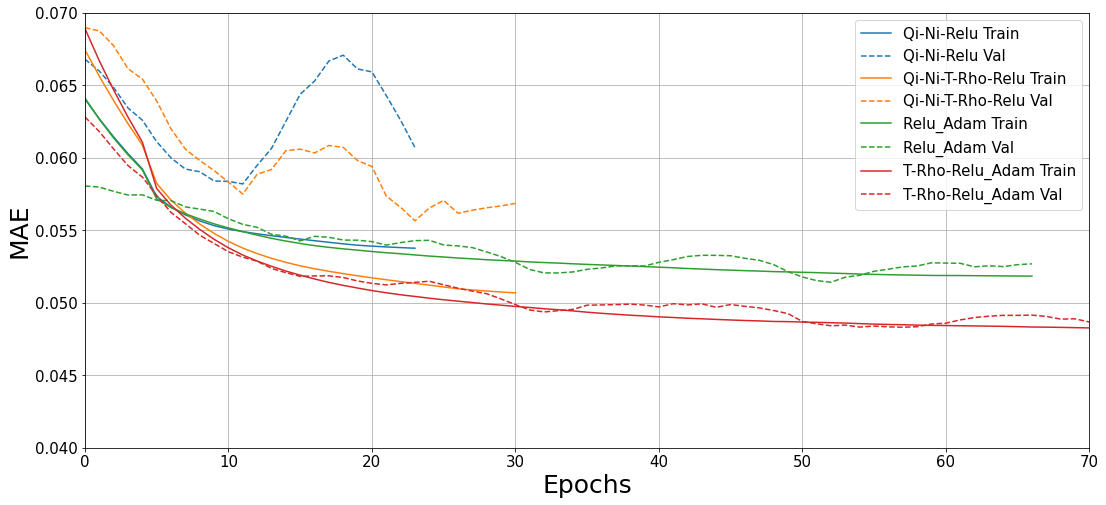

In [54]:
histories['T-rho-ReLU_Adam'] = early_history7

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.07])
plt.ylabel('MAE')

In [55]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

34489/34489 - 1s - loss: 0.0055 - mae: 0.0527 - mse: 0.0055
Testing set for model 4, Mean Abs Error:              0.05271


In [56]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

34489/34489 - 1s - loss: 0.0048 - mae: 0.0492 - mse: 0.0048
Testing set for model 5, Mean Abs Error:              0.04922


In [57]:
loss6, mae6, mse6 = model6.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 6, Mean Abs Error: {:20.5f}".format(mae6))

34489/34489 - 1s - loss: 0.0050 - mae: 0.0508 - mse: 0.0050
Testing set for model 6, Mean Abs Error:              0.05080


In [58]:
loss7, mae7, mse7 = model7.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 7, Mean Abs Error: {:20.5f}".format(mae7))

34489/34489 - 1s - loss: 0.0043 - mae: 0.0472 - mse: 0.0043
Testing set for model 7, Mean Abs Error:              0.04721


In [59]:
mae = [ mae4, mae5, mae6, mae7 ]
mae

[0.052705593, 0.049220107, 0.050798137, 0.04720899]

In [60]:
mse = [ mse4, mse5, mse6, mse7 ]
mse

[0.0055234265, 0.0047943066, 0.0050451476, 0.0042963144]

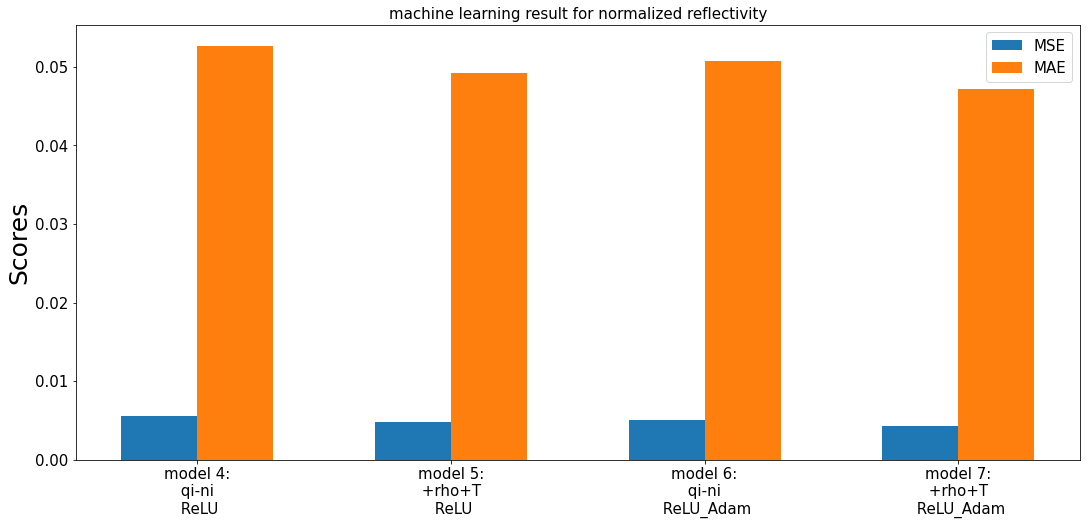

In [61]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = [
 'model 4:\n qi-ni \n ReLU',
 'model 5:\n +rho+T \n ReLU',
 'model 6:\n qi-ni \n ReLU_Adam',
 'model 7:\n +rho+T \n ReLU_Adam' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized reflectivity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [62]:
test_true_z  = np.exp(test_labels.pop('z_s'))

In [63]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [64]:
p1 = pd.DataFrame(data=model4.predict(normed_test_data1), columns=["z_s"])

In [65]:
p1.describe()

z_s
count  34489.000000
mean      -0.005985
std        0.998584
min       -2.894041
25%       -0.751552
50%       -0.080008
75%        0.721445
max        2.976335

In [66]:
train_labels_stats

count       mean       std        min        25%        50%  \
z_s  161476.0 -30.490215  2.398724 -37.440689 -32.287439 -30.680291   

           75%        max  
z_s -28.756599 -23.289139

In [67]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [68]:
test_predict1.describe()

z_s
count  3.448900e+04
mean   7.622183e-13
std    2.966580e-12
min    5.538523e-17
25%    9.447931e-15
50%    4.730631e-14
75%    3.234707e-13
max    7.225572e-11

In [69]:
test_predict1_z  = test_predict1['z_s']

In [70]:

p2 = pd.DataFrame(data=model5.predict(normed_test_data3), columns=["z_s"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_z = test_predict2['z_s']

In [71]:

p3 = pd.DataFrame(data=model6.predict(normed_test_data1), columns=["z_s"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_z = test_predict3['z_s']

In [72]:

p5 = pd.DataFrame(data=model7.predict(normed_test_data3), columns=["z_s"])

test_predict5 = np.exp(backtransform(p5,train_labels_stats))

test_predict5_z  = test_predict5['z_s']

### Maybe the ordering of the arrays is different? 

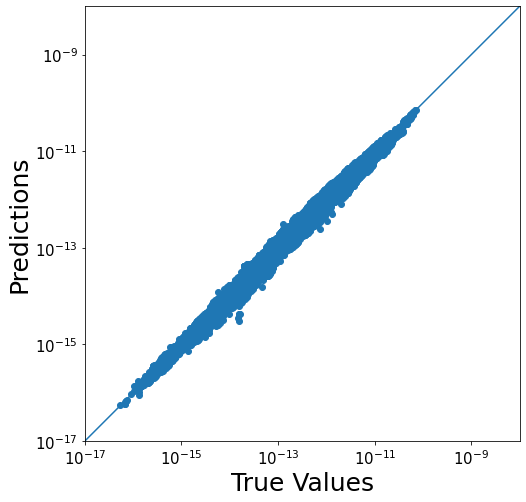

In [73]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-17, 1e-8

a = plt.axes(aspect='equal')
plt.scatter(test_true_z, test_predict1_z)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

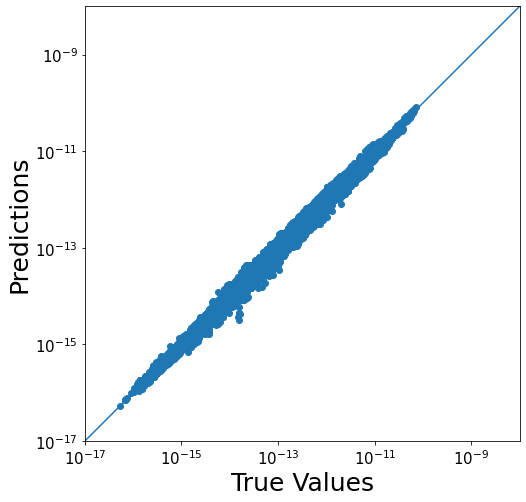

In [74]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_z, test_predict2_z)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

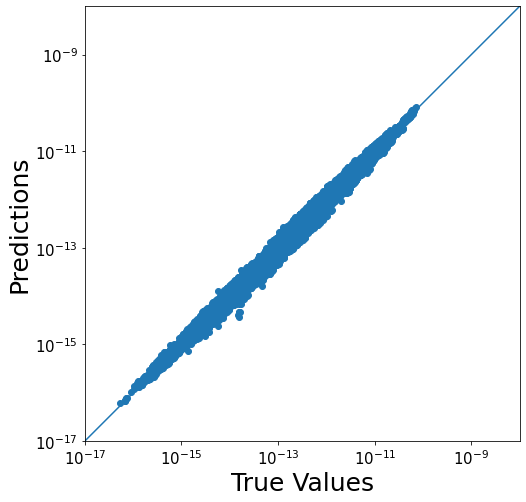

In [75]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_z, test_predict3_z)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

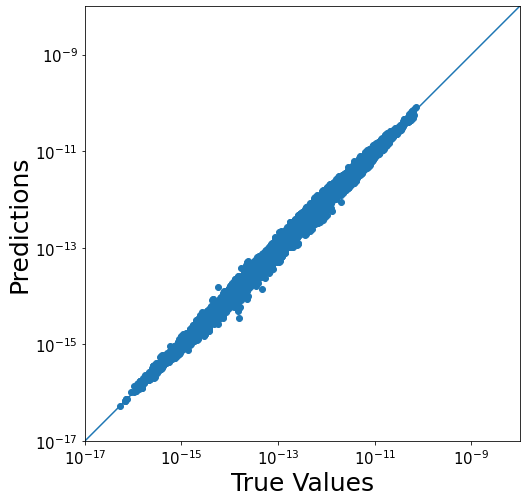

In [76]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_z, test_predict5_z)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [77]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [78]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [79]:
features = 'q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice'
labels   = 'z_rimedice'
logtransform = np.array([True, True, True, True], dtype=bool)
save2netcdf(model4,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/refl_rimedice_model4_'+version+'.nc')
save2netcdf(model6,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/refl_rimedice_model6_'+version+'.nc')

Saving model to saved_model_v2/refl_rimedice_model4_06.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice
  Labels:     z_rimedice
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/refl_rimedice_model6_06.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice
  Labels:     z_rimedice
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>

In [80]:

features = 'q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, temp, rho'
logtransform = np.array([True, True, True, True, False, False], dtype=bool)
save2netcdf(model5,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/refl_rimedice_model5_'+version+'.nc')
save2netcdf(model7,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/refl_rimedice_model7_'+version+'.nc')

Saving model to saved_model_v2/refl_rimedice_model5_06.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, temp, rho
  Labels:     z_rimedice
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/refl_rimedice_model7_06.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, temp, rho
  Labels:     z_rimedice
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.ker